# The mechanics of learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/deeplearning_with_pytorch")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [5]:
# make a model that will linearly estimate t_c using t_u
def model(t_u, w, b):
    return w * t_u + b

In [6]:
# define a loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [7]:
# initialize weights and bias
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [8]:
# compute loss
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [9]:
# broadcasting example
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [10]:
# computing gradient- naive
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w+delta, b), t_c) - 
     loss_fn(model(t_u, w-delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w

tensor(4517.2974)

In [11]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [12]:
w

tensor(-44.1730)

In [13]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

print(loss_rate_of_change_b)
print(b)

tensor(-4600.)
tensor(46.)


In [14]:
# simple representation of how gradient calculation would be done using chain rule
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('   Params:', params)
                print('   Grad:   ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break
    
    return params

In [17]:
# loss does not converge as learning rate is too high
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c= t_c
)

Epoch 1, Loss 1763.884766
   Params: tensor([-44.1730,  -0.8260])
   Grad:    tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
   Params: tensor([2568.4011,   45.1637])
   Grad:    tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
   Params: tensor([-148527.7344,   -2616.3931])
   Grad:    tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
   Params: tensor([3.2144e+17, 5.6621e+15])
   Grad:    tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
   Params: tensor([-1.8590e+19, -3.2746e+17])
   Grad:    tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [18]:
# model fits better, but gradietns is much larger for w
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884766
   Params: tensor([ 0.5483, -0.0083])
   Grad:    tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
   Params: tensor([ 0.3623, -0.0118])
   Grad:    tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
   Params: tensor([ 0.2858, -0.0135])
   Grad:    tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
   Params: tensor([ 0.2324, -0.0166])
   Grad:    tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
   Params: tensor([ 0.2323, -0.0169])
   Grad:    tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
   Params: tensor([ 0.2327, -0.0435])
   Grad:    tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
   Params: tensor([ 0.2327, -0.0438])
   Grad:    tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [19]:
# normalized t_u
t_un = 0.1 * t_u

In [20]:
# much better gradients
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.364342
   Params: tensor([1.7761, 0.1064])
   Grad:    tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
   Params: tensor([2.0848, 0.1303])
   Grad:    tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
   Params: tensor([2.2094, 0.1217])
   Grad:    tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
   Params: tensor([ 2.3232, -0.0710])
   Grad:    tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
   Params: tensor([ 2.3284, -0.1003])
   Grad:    tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
   Params: tensor([ 2.7508, -2.4910])
   Grad:    tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
   Params: tensor([ 2.7553, -2.5162])
   Grad:    tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [21]:
# increase number of epochs
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

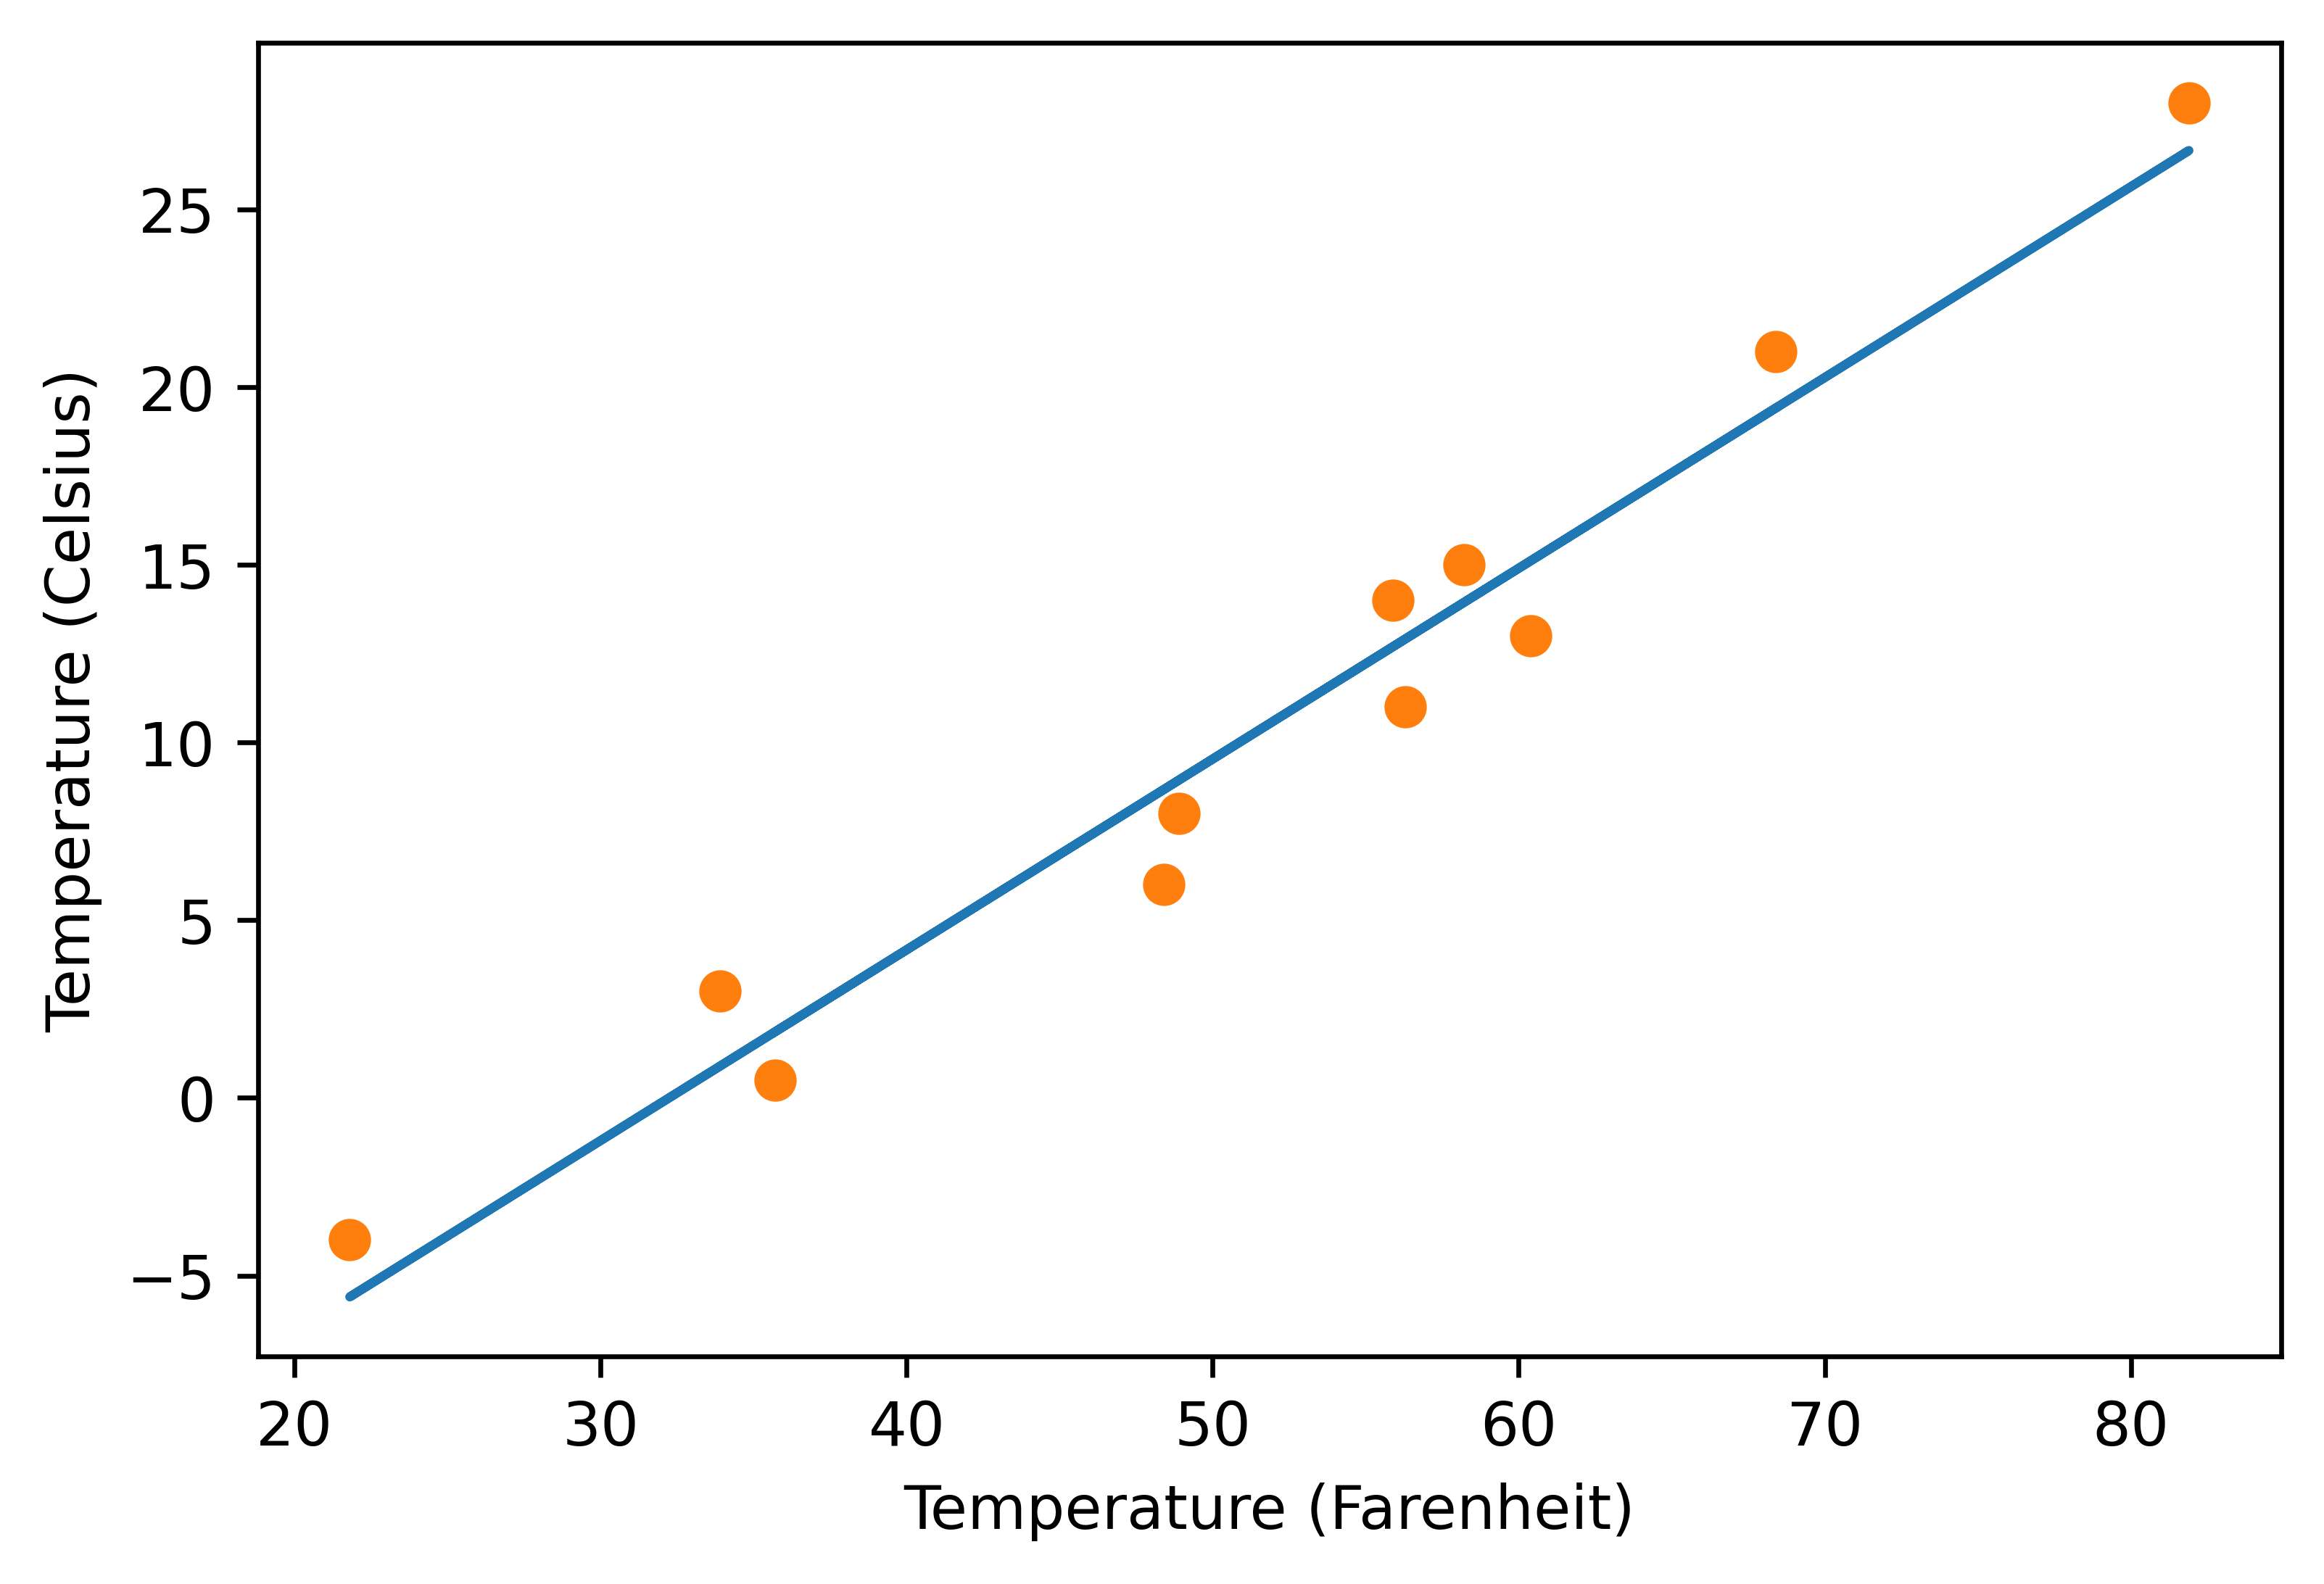

In [22]:
# two values are in fact farenheit and celsius
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (Farenheit)")
plt.ylabel("Temperature (Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

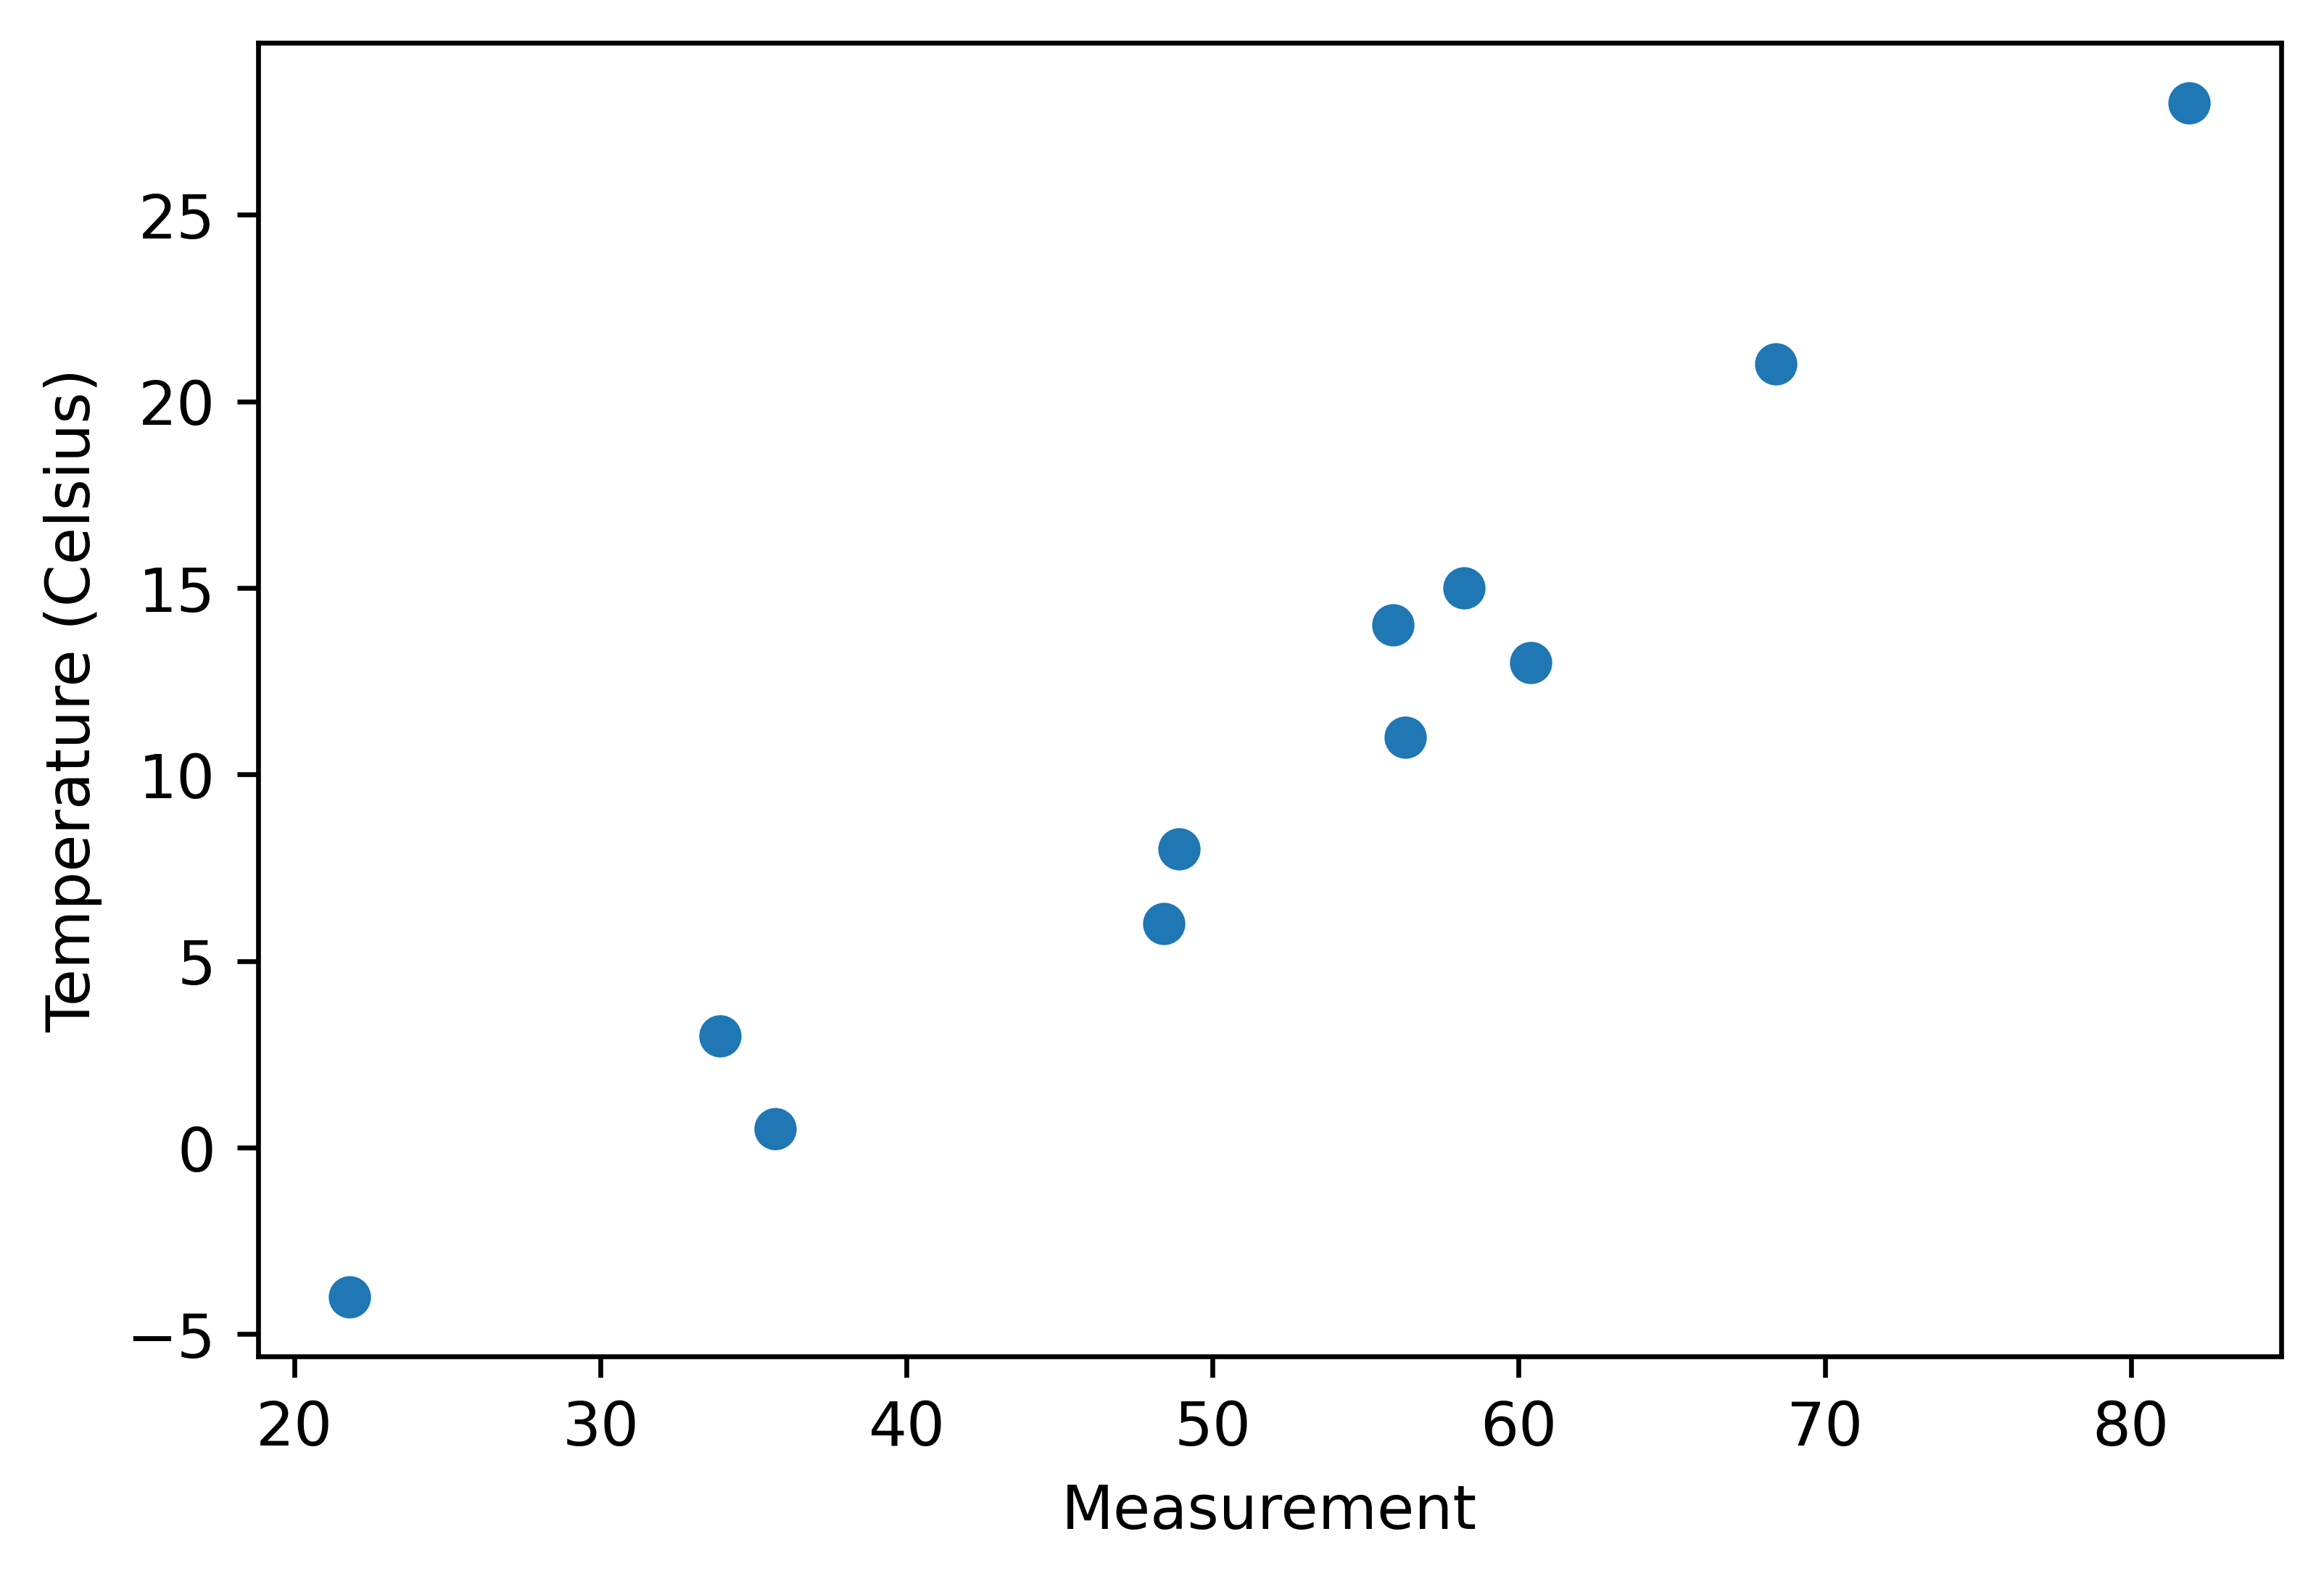

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

## AutoGrad

In [24]:
# AutoGrad in pytorch keeps track of gradient calculation
# calculation gets accumulated, so always zero out before calculation

# requires_grad = True to keep track of gradients
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [25]:
params.grad is None

True

In [26]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

print(params)
print(params.grad)

tensor([1., 0.], requires_grad=True)
tensor([4517.2969,   82.6000])


In [27]:
# to zero out, use grad.zero_()

if params.grad is not None:
    params.grad.zero_()

In [28]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
      
    return params

In [29]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers

In [30]:
# optimizer comes in handy for adapting learning rates
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [31]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [32]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

# use step in optimizer to update parameters
# dont forget to zero out in the loop
optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # zeroing out the gradient should be added
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [34]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

In [35]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [36]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c
)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

In [37]:
# shuffle indices to create validation and training set
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  7,  0,  3,  6,  2,  5,  9, 10]), tensor([4, 8]))

In [38]:
# split into validation and training set
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [43]:
# optimizer uses only the trainig loss
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f"Validation loss {val_loss.item():.4f}")
        
    return params

In [44]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

Epoch 1, Training loss 94.8695,Validation loss 15.0912
Epoch 2, Training loss 41.5927,Validation loss 5.0624
Epoch 3, Training loss 33.5647,Validation loss 12.8680
Epoch 500, Training loss 6.1184,Validation loss 11.9401
Epoch 1000, Training loss 2.6418,Validation loss 9.3247
Epoch 1500, Training loss 2.1846,Validation loss 8.4743
Epoch 2000, Training loss 2.1245,Validation loss 8.1789
Epoch 2500, Training loss 2.1166,Validation loss 8.0734
Epoch 3000, Training loss 2.1155,Validation loss 8.0354


tensor([  5.3613, -16.7575], requires_grad=True)

In [45]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        # we can also just turn off grad tracking for val loss
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()


In [46]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss